# Combining Marine Vessel Traffic and Sea Ice Concentration Data

In this notebook, we demonstrate a method for combining the [North Pacific and Arctic Marine Vessel Traffic Dataset](https://www.sciencedirect.com/science/article/pii/S2352340922007387) with [Historical Sea Ice Concentration](https://snap.uaf.edu/tools/sea-ice-atlas) data from the SNAP Data API. Vessel traffic data has been pre-aggregated into hexagons, and we use the centroids of those hexagons to query SNAP Data API for sea ice concentration. We then summarize and plot vessel traffic over time within the Bering Sea zone. 

The intention of this notebook is to show the fusion of SNAP Data API products with vector and tabular datasets. This offers an alternative to acessing raster datasets by using polygon zonal statistics, a method which is covered in other ARDAC notebooks.

Vessel traffic data should be downloaded from [here](https://search.dataone.org/view/doi%3A10.18739%2FA2XG9FC41) and unzipped locally before running the notebook. A shapefile of the continents is also used for context in plotting; optionally, that data can be downloaded [here](https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip). 

### Setup
Load required packages.

In [1]:
import pandas as pd
import geopandas as gpd
import aiohttp
import asyncio
import os
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np

### Read in vessel traffic data

Given the directory with all unzipped vessel traffic hexagon shapefiles, list them and iterate through the list to read them into `GeoDataFrame`s. Concatenate all of them into one `GeoDataFrame`. According to the metadata, these hexagons and their coordinates are in the Alaska Albers projection (EPSG:3338). But in order to query the API, we need point locations in WGS84 (EPSG:4326). So we will extract the centroid of each hexagon, convert the coordinates to EPSG:4326, and add those as new geometric attributes. We also add an empty attribute to hold sea ice concentration values that we will fetch via the SNAP Data API.

In [2]:
data_dir = "/home/UA/jdpaul3/testing/ARDAC_nbs/data/data"

paths = []
for root, dir, files in os.walk(data_dir):
    for f in files:
        if f.endswith(".shp"):
            paths.append(os.path.join(root, f))

crs = gpd.read_file(paths[0]).crs
gdf_3338 = gpd.GeoDataFrame(
    pd.concat([gpd.read_file(i).to_crs(crs) for i in paths], ignore_index=True), crs=crs
)

gdf_3338["centroid"] = gdf_3338.geometry.centroid
gdf_4326 = gdf_3338.set_geometry(col="centroid").to_crs(4326)
gdf_3338["LON_4326"] = gdf_4326.geometry.x
gdf_3338["LAT_4326"] = gdf_4326.geometry.y
# optionally, save the concatenated output for future use
# gdf_3338.to_file("/path/to/save/data/shipping_hex_concat.shp")
gdf_3338["sea_ice_concentration"] = None

gdf_3338.head()

,hexID,year,month,SOG_C,SOGsd_C,nMMSI_C,nOprD_C,SOG_T,SOGsd_T,nMMSI_T,...,nOPrD_L,SOG_A,SOGsd_A,nMMSI_A,nOprD_A,geometry,centroid,LON_4326,LAT_4326,sea_ice_concentration
0,1,2020,08,20.325000,0.046291,1.0,1.0,NaN,NaN,NaN,...,1.0,20.325000,0.046291,1.0,1.0,"POLYGON ((-1541845.047 226864.240, -1534090.00...",POINT (-1526334.971 226864.240),-175.375793,49.810191,None
1,2,2020,08,13.136860,1.395568,9.0,9.0,NaN,NaN,NaN,...,10.0,13.084026,1.368019,10.0,10.0,"POLYGON ((-1495314.819 226864.240, -1487559.78...",POINT (-1479804.743 226864.240),-174.766395,49.941912,None
2,3,2020,08,13.985930,0.701876,7.0,7.0,NaN,NaN,NaN,...,8.0,13.365106,1.604872,8.0,8.0,"POLYGON ((-1448784.590 226864.240, -1441029.55...",POINT (-1433274.514 226864.240),-174.153359,50.069897,None
3,4,2020,08,14.961905,1.757691,5.0,5.0,NaN,NaN,NaN,...,5.0,14.961905,1.757691,5.0,5.0,"POLYGON ((-1565110.162 240296.360, -1557355.12...",POINT (-1549600.085 240296.360),-175.738457,49.858383,None
4,5,2020,08,13.304803,1.725948,18.0,18.0,NaN,NaN,NaN,...,18.0,13.304803,1.725948,18.0,18.0,"POLYGON ((-1518579.933 240296.360, -1510824.89...",POINT (-1503069.857 240296.360),-175.129475,49.992279,None


### Plot hexagons and lines of latitude for context

Next, we will plot some data for spatial context. Read in the continents shapefile, create a standalone hexagon `GeoDataFrame`, and plot them together. For the lines of latitude, we need to transform the geographic coordinates into EPSG:3338, so we build a transformer and list of latitudes to iterate over. We actually need to create two lines of latitude in order to deal with the dateline at longitude -180/180. So we will use `np.linspace()` to fill in two lists of longitude coordinates (160 to 180, and -180 to -135) which we then plot with identical styles. These two lines meet on the map and appear as one. Finally, we add some annotation.

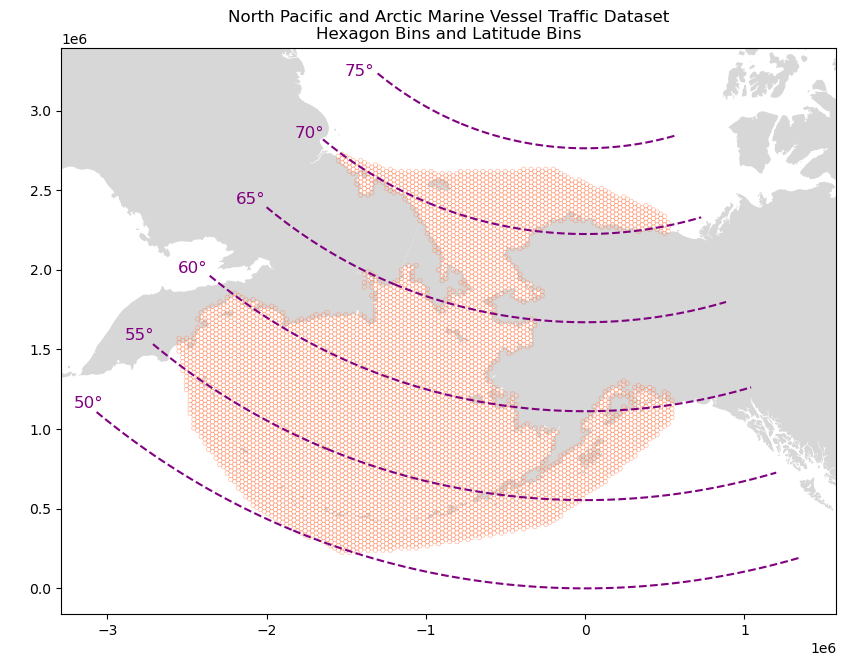

In [3]:
continents_3338 = gpd.read_file(
    "/home/UA/jdpaul3/testing/ARDAC_nbs/data/continent.shp"
).to_crs(3338)

hex_geom_3338 = gdf_3338.groupby("hexID", as_index=False)["geometry"].first()

fig, ax = plt.subplots(figsize=(10, 10))
hex_geom_3338.boundary.plot(
    figsize=(10, 10), ax=ax, linewidth=0.5, alpha=0.5, color="coral"
)
continents_3338.plot(ax=ax, linewidth=0.7, alpha=0.9, color="lightgray")

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3338", always_xy=True)
lats = [50, 55, 60, 65, 70, 75]

for lat in lats:
    lon1 = np.linspace(160, 180)
    lon2 = np.linspace(-180, -135)
    lat_ = np.linspace(lat, lat)
    x1, y1 = transformer.transform(xx=lon1, yy=lat_)
    x2, y2 = transformer.transform(xx=lon2, yy=lat_)
    ax.plot(x1, y1, linewidth=1.5, color="purple", linestyle="--")
    ax.plot(x2, y2, linewidth=1.5, color="purple", linestyle="--")

ax.annotate(
    "50\N{DEGREE SIGN}",
    xy=(53, 186),
    xycoords="figure points",
    fontsize=12,
    color="purple",
)
ax.annotate(
    "55\N{DEGREE SIGN}",
    xy=(90, 235),
    xycoords="figure points",
    fontsize=12,
    color="purple",
)
ax.annotate(
    "60\N{DEGREE SIGN}",
    xy=(128, 283),
    xycoords="figure points",
    fontsize=12,
    color="purple",
)
ax.annotate(
    "65\N{DEGREE SIGN}",
    xy=(170, 333),
    xycoords="figure points",
    fontsize=12,
    color="purple",
)
ax.annotate(
    "70\N{DEGREE SIGN}",
    xy=(212, 380),
    xycoords="figure points",
    fontsize=12,
    color="purple",
)
ax.annotate(
    "75\N{DEGREE SIGN}",
    xy=(248, 425),
    xycoords="figure points",
    fontsize=12,
    color="purple",
)

ax.set_xlim(-3289000, 1577000)
ax.set_ylim(-161600, 3395000)

ax.set_title(
    "North Pacific and Arctic Marine Vessel Traffic Dataset\nHexagon Bins and Latitude Bins"
)
plt.show()

Using the plot above, we can better visualize how our analysis will work. We are going to limit our analysis to the latitudes around the Bering Sea, so we will first select only those hexagons between 62 and 68 degrees latitude and between -160 and -175 longitude. With the centroid of each Bering Sea hexagon, we will query sea ice concentration for that year and month and add it to the dataset. We can then sum the vessel operating days, average the sea ice concentration, and plot the relationship. 

While this analysis is rather basic and exploratory, it opens the door for more possibilities in working with this dataset and demonstrates some methods you can use to aggregate and visualize the datasets.

### Fetching sea ice data from SNAP Data API

 First we drop any hexagons with latitude outside of our range. 
 
 Second we get our hexagon centroids. There are multiple years in the vessel traffic dataset, and each one uses the same hexagon grid. Due to the JSON structure of the [sea ice endpoint](https://earthmaps.io/seaice/), we actually only need to request sea ice data once for each hexagon centroid and the SNAP Data API will return all the years and months we need. So we use a `groupby()` operation and grab just the first hexagon.

Using each corresponding EPSG:4326 coordinate pair, we create a dictionary with hexagon IDs as keys and the SNAP Data API request URL as the values.

In [4]:
bering_3338 = gdf_3338[
    (gdf_3338["LAT_4326"] > 62)
    & (gdf_3338["LAT_4326"] < 68)
    & (gdf_3338["LON_4326"] < -160)
    & (gdf_3338["LON_4326"] > -175)
].copy()
hexid_coords = bering_3338.groupby("hexID")[["LON_4326", "LAT_4326"]].first()

hexid_url_dict = {}
for hexid, row in hexid_coords.iterrows():
    lon_str = str(row.LON_4326)
    lat_str = str(row.LAT_4326)
    request_url = str("https://earthmaps.io/seaice/point/" + lat_str + "/" + lon_str)
    hexid_url_dict[hexid] = request_url

Next we set up `async` request functions: this set of functions opens an HTTP session and makes multiple simultaneous requests to the server. The `main()` function updates an input dictionary with items containing hexagon IDs as keys and JSON responses as values.

In [5]:
async def fetch(session, hexid, url):
    async with session.get(url) as response:
        if response.status != 200:
            print("BAD REQUEST : HEXID " + str(hexid) + ", URL: " + url)
            print("HEXID " + str(hexid) + " will have no results...")
            none_dict = {hexid: None}
            return none_dict
        else:
            hexid_json_dict = {hexid: await response.json()}
            return hexid_json_dict


async def fetch_all(session, hexid_url_dict):
    tasks = []
    for key in hexid_url_dict:
        task = asyncio.create_task(fetch(session, key, hexid_url_dict[key]))
        tasks.append(task)
    results = await asyncio.gather(*tasks)
    return results


async def main(dict_, result_dict):
    timeout = aiohttp.ClientTimeout(total=900)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        hexid_json_dicts = await fetch_all(session, dict_)
        for d in hexid_json_dicts:
            result_dict.update(d)

Run the function for each hexagon ID/URL dictionary, populating the results dictionary with hexagon ID/JSON sea ice data combinations.

In [6]:
result = {}
await main(hexid_url_dict, result)

Now we can populate the sea ice concentration attribute of the original vessel traffic `GeoDataFrame` using its year, month, and hexagon ID attributes. For each hexagon, we call the proper result dictionary using a concatenated year-month string. This code snippet also provides an error message if the hexagon ID is not present in the results dictionary, to alert the user that the requested year-month combination is not available in the sea ice dataset.

In [7]:
for index, row in bering_3338.iterrows():
    hexid = row.hexID
    ym_key = str(row.year) + "-" + str(row.month)
    try:
        sea_ice_concentration = result[hexid][ym_key]
        bering_3338.loc[index, "sea_ice_concentration"] = sea_ice_concentration
    except:
        print("bad hex/key combo: " + str(hexid) + " : " + ym_key)

Now we can work with the combined vessel/sea ice data! 

For reference the `nOprD_<suffix>` attributes denote number of operating days with each hexagon. There are six different subsets of vessel data: all vessels (denoted with suffix “_A”), and vessels categorized by ship type (cargo "\_C", tanker "\_T", fishing "\_F", other "\_O"). For this analysis we will look at each of the categories.

Start by filling NA values with 0s to avoid unintended statistics errors. (In this case, we want to specify that an observation of no vessels is actually a numerical 0, and not an NA value that might be skipped by the function.)

We want to apply two different functions to the attributes aggregated into monthly bins; sum for vessel operating days (all categories), and mean for sea ice concentration. We use a dictionary to define these functions explicitly for each of the attributes in the dataset, and use that dictionary in the `groupby` operation.

Lastly, we invert the sea ice concentration attribute to get a corresponding `open_water_pct` attribute, and create a new column to hold a `datetime` object for easier plotting.

In [8]:
bering_3338.fillna(0, inplace=True)

# bins = [50, 55, 60, 65, 70, 75]
# group_names = ["50-55", "55-60", "60-65", "65-70", "70-75"]
# bering_3338["lat_bins"] = pd.cut(bering_3338["LAT_4326"], bins, labels=group_names)

f = {
    "nOprD_A": "sum",
    "nOprD_C": "sum",
    "nOprD_T": "sum",
    "nOprD_F": "sum",
    "nOprD_O": "sum",
    "sea_ice_concentration": "mean",
}
df = bering_3338.groupby(["year", "month"], observed=True, as_index=False).agg(f)
df["open_water_pct"] = 100 - df["sea_ice_concentration"]
df["day"] = 1
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df

,year,month,nOprD_A,nOprD_C,nOprD_T,nOprD_F,nOprD_O,sea_ice_concentration,open_water_pct,day,date
0,2015,01,0.0,0.0,0.0,0.0,0.0,63.155357,36.844643,1,2015-01-01
1,2015,02,0.0,0.0,0.0,0.0,0.0,80.632143,19.367857,1,2015-02-01
2,2015,03,0.0,0.0,0.0,0.0,0.0,82.044643,17.955357,1,2015-03-01
3,2015,04,78.0,51.0,0.0,0.0,27.0,82.114286,17.885714,1,2015-04-01
4,2015,05,370.0,99.0,0.0,4.0,267.0,30.0875,69.9125,1,2015-05-01
...,...,...,...,...,...,...,...,...,...,...,...
67,2020,08,7010.0,2377.0,1169.0,544.0,2920.0,0.123214,99.876786,1,2020-08-01
68,2020,09,6073.0,1457.0,1180.0,497.0,2939.0,1.585714,98.414286,1,2020-09-01
69,2020,10,4835.0,1546.0,936.0,333.0,2020.0,1.616071,98.383929,1,2020-10-01
70,2020,11,1648.0,426.0,176.0,646.0,400.0,2.801786,97.198214,1,2020-11-01


Let's also compute a yearly total of operating days for each category. We will use 7/1 as the date for these records, so that we can plot them alongside the monthly data in the most active summer months.

In [9]:
df_year = df.groupby("year", observed=True, as_index=False).agg(f)
df_year["day"] = 1
df_year["month"] = 7
df_year["date"] = pd.to_datetime(df_year[["year", "month", "day"]])
df_year

,year,nOprD_A,nOprD_C,nOprD_T,nOprD_F,nOprD_O,sea_ice_concentration,day,month,date
0,2015,26046.0,6279.0,1699.0,1519.0,16549.0,33.691518,1,7,2015-07-01
1,2016,24815.0,7730.0,1797.0,1402.0,13886.0,31.092262,1,7,2016-07-01
2,2017,23739.0,6556.0,1959.0,2150.0,13074.0,28.054464,1,7,2017-07-01
3,2018,22933.0,5369.0,1843.0,2656.0,13065.0,18.205804,1,7,2018-07-01
4,2019,26648.0,6024.0,3501.0,2909.0,14214.0,19.141964,1,7,2019-07-01
5,2020,27703.0,7318.0,4501.0,3071.0,12813.0,28.579315,1,7,2020-07-01


### Plotting open water & vessel operating days by category

Now that we have all of our data combined and aggregated, we can plot vessel operating days against open water percentage for each category.

/tmp/ipykernel_2748/45612289.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  twin_b.set_xticklabels(ticklabels, ha='left')
/tmp/ipykernel_2748/45612289.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  twin_b.set_xticklabels(ticklabels, ha='left')
/tmp/ipykernel_2748/45612289.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  twin_b.set_xticklabels(ticklabels, ha='left')
/tmp/ipykernel_2748/45612289.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  twin_b.set_xticklabels(ticklabels, ha='left')
/tmp/ipykernel_2748/45612289.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

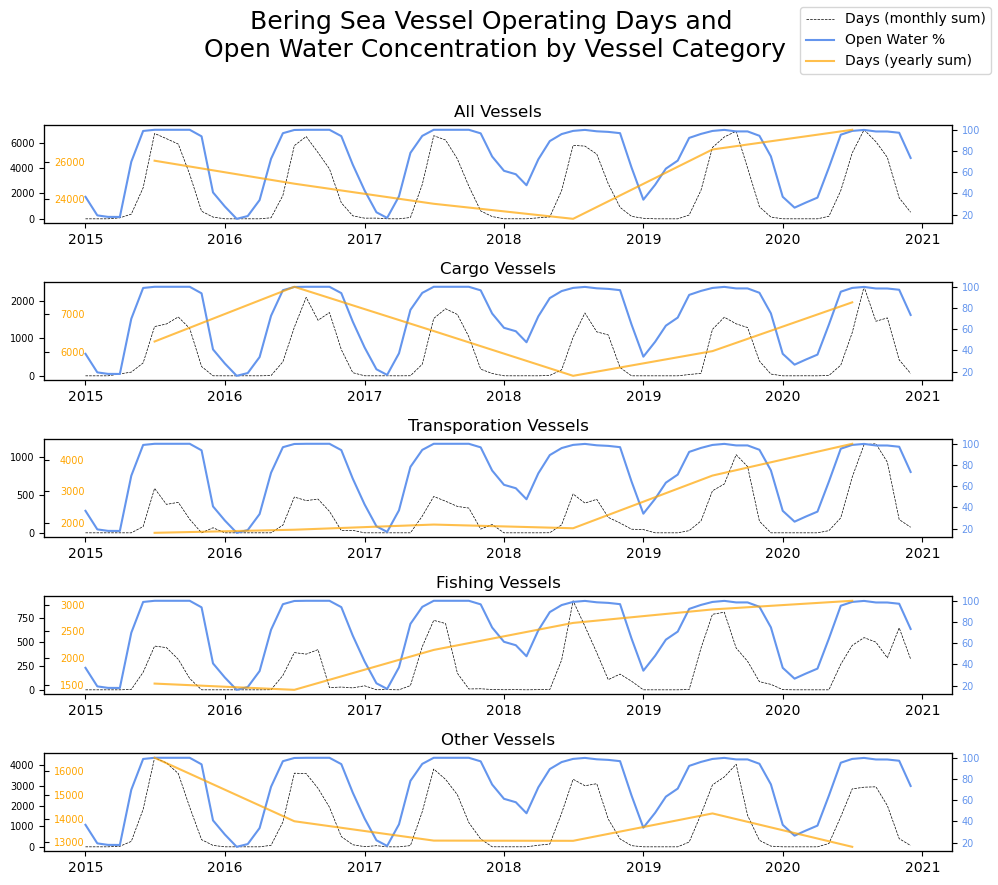

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 8))
f = 7

axes = [ax1, ax2, ax3, ax4, ax5]
ax1a, ax2a, ax3a, ax4a, ax5a = (
    ax1.twinx(),
    ax2.twinx(),
    ax3.twinx(),
    ax4.twinx(),
    ax5.twinx(),
)
ax1b, ax2b, ax3b, ax4b, ax5b = (
    ax1.twinx(),
    ax2.twinx(),
    ax3.twinx(),
    ax4.twinx(),
    ax5.twinx(),
)
twin_axes_a = [ax1a, ax2a, ax3a, ax4a, ax5a]
twin_axes_b = [ax1b, ax2b, ax3b, ax4b, ax5b]


vessel_cats = ["nOprD_A", "nOprD_C", "nOprD_T", "nOprD_F", "nOprD_O"]
vessel_labels = [
    "All Vessels",
    "Cargo Vessels",
    "Transporation Vessels",
    "Fishing Vessels",
    "Other Vessels",
]

for cat, label, ax, twin_a, twin_b in zip(
    vessel_cats, vessel_labels, axes, twin_axes_a, twin_axes_b
):
    x1 = df.date
    y1 = df[cat]

    x2 = df_year.date
    y2 = df_year[cat]

    y3 = df.open_water_pct

    # ax.set_ylabel("Days (monthly sum)", color="black", fontsize=f)
    ax.tick_params(axis="y", labelcolor="black", labelsize=f)
    ax.plot(
        x1, y1, color="black", linewidth=0.5, linestyle="--", label="Days (monthly sum)"
    )

    # twin_b.set_ylabel("Days (yearly sum)", color="orange", fontsize=f)
    twin_b.yaxis.set_label_position("left")
    twin_b.yaxis.set_ticks_position("left")
    twin_b.tick_params(
        axis="y", labelcolor="orange", direction="in", labelsize=f, pad=-29
    )
    ticklabels = twin_b.get_xticklabels()
    twin_b.set_xticklabels(ticklabels, ha="left")
    twin_b.plot(x2, y2, color="orange", alpha=0.7, label="Days (yearly sum)")

    # twin_a.set_ylabel("Open Water %", color="lightblue", fontsize=f)
    twin_a.tick_params(axis="y", labelcolor="cornflowerblue", labelsize=f)
    twin_a.plot(x1, y3, color="cornflowerblue", label="Open Water %")

    ax.set_title(label)

    # first iteration will provide lines/labels for the legend
    if cat == "nOprD_A":
        lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines, labels)

fig.tight_layout()
fig.suptitle(
    "Bering Sea Vessel Operating Days and \nOpen Water Concentration by Vessel Category",
    y=1.1,
    fontsize=18,
)
plt.show()

### Mapping monthly mean sea ice concentration

Group the data by hexagon ID and month, and make plots of mean 2015-2020 sea ice concentration for each month. As in the first context map, add the latitude lines. We can see that, on average, sea ice is nearly continuous by December and stays continuous until April.

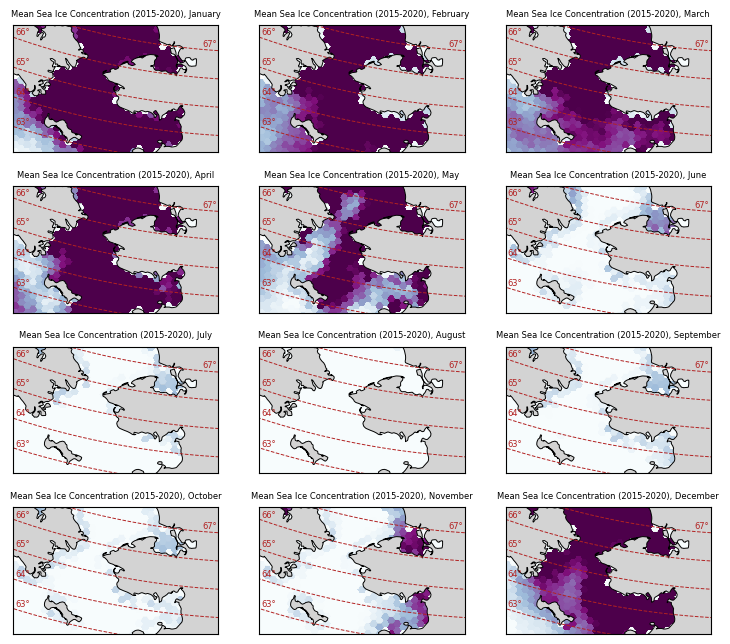

In [11]:
map_df = (
    bering_3338[
        bering_3338["month"].isin(
            ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
        )
    ]
    .groupby(["hexID", "month"], observed=True, as_index=False)["sea_ice_concentration"]
    .mean()
)
map_df = map_df.merge(bering_3338[["hexID", "geometry"]], on="hexID")
map_gdf = gpd.GeoDataFrame(map_df, geometry="geometry", crs=3338)

fig, (
    (ax1, ax2, ax3),
    (ax4, ax5, ax6),
    (ax7, ax8, ax9),
    (ax10, ax11, ax12),
) = plt.subplots(4, 3, figsize=(9, 8))

vmin = 0
vmax = 100
f = 6

for m, ax, m_name in zip(
    ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12],
    [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ],
):
    df = map_gdf[map_gdf["month"] == m]
    df.plot(
        "sea_ice_concentration",
        cmap="BuPu",
        ax=ax,
        alpha=0.7,
        zorder=0,
        vmin=vmin,
        vmax=vmax,
    )

    continents_3338.plot(ax=ax, linewidth=0.7, fc="lightgray", ec="black", zorder=1)

    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3338", always_xy=True)
    lats = [62, 63, 64, 65, 66, 67, 68]

    for lat in lats:
        lon1 = np.linspace(160, 180)
        lon2 = np.linspace(-180, -135)
        lat_ = np.linspace(lat, lat)
        x1, y1 = transformer.transform(xx=lon1, yy=lat_)
        x2, y2 = transformer.transform(xx=lon2, yy=lat_)
        ax.plot(x1, y1, linewidth=0.7, color="firebrick", linestyle="--")
        ax.plot(x2, y2, linewidth=0.7, color="firebrick", linestyle="--")

    ax.annotate(
        "63\N{DEGREE SIGN}",
        xy=(0.01, 0.21),
        xycoords="axes fraction",
        fontsize=f,
        color="firebrick",
    )
    ax.annotate(
        "64\N{DEGREE SIGN}",
        xy=(0.01, 0.45),
        xycoords="axes fraction",
        fontsize=f,
        color="firebrick",
    )
    ax.annotate(
        "65\N{DEGREE SIGN}",
        xy=(0.01, 0.69),
        xycoords="axes fraction",
        fontsize=f,
        color="firebrick",
    )
    ax.annotate(
        "66\N{DEGREE SIGN}",
        xy=(0.01, 0.92),
        xycoords="axes fraction",
        fontsize=f,
        color="firebrick",
    )
    ax.annotate(
        "67\N{DEGREE SIGN}",
        xy=(0.92, 0.83),
        xycoords="axes fraction",
        fontsize=f,
        color="firebrick",
    )

    ax.set_xlim(-1000000, -190000)
    ax.set_ylim(1500000, 2000000)

    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set_title("Mean Sea Ice Concentration (2015-2020), " + m_name, fontsize=f)

plt.show()

### "Small multiples" maps of sea ice concentration by month and year

Group the data by hexagon ID, year, and month. We will only use April-December, assuming that sea ice is nearly continuous during the deep winter months. Plot the mean sea ice concentration for all month/year combinations from April-December. This will show us trends for each month, and highlights that the "shoulder season" months have seen the most dramatic changes from 2015-2020.

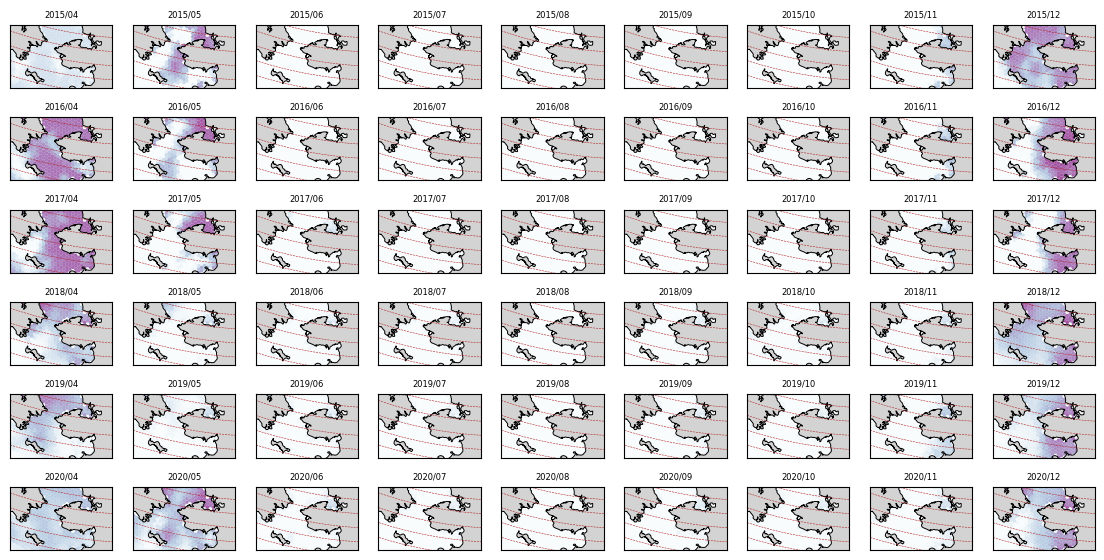

In [13]:
map_df = (
    bering_3338[
        bering_3338["month"].isin(
            ["04", "05", "06", "07", "08", "09", "10", "11", "12"]
        )
    ]
    .groupby(["hexID", "year", "month"], observed=True, as_index=False)[
        "sea_ice_concentration"
    ]
    .mean()
)
map_df = map_df.merge(
    bering_3338.groupby("hexID", as_index=False)["geometry"].first(),
    how="left",
    on="hexID",
)

map_gdf = gpd.GeoDataFrame(map_df, geometry="geometry", crs=3338)

fig, (
    (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9),
    (ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18),
    (ax19, ax20, ax21, ax22, ax23, ax24, ax25, ax26, ax27),
    (ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36),
    (ax37, ax38, ax39, ax40, ax41, ax42, ax43, ax44, ax45),
    (ax46, ax47, ax48, ax49, ax50, ax51, ax52, ax53, ax54),
) = plt.subplots(6, 9, figsize=(14, 7))

vmin = 0
vmax = 100
f = 6

for year, month, ax in zip(
    [
        "2015",
        "2015",
        "2015",
        "2015",
        "2015",
        "2015",
        "2015",
        "2015",
        "2015",
        "2016",
        "2016",
        "2016",
        "2016",
        "2016",
        "2016",
        "2016",
        "2016",
        "2016",
        "2017",
        "2017",
        "2017",
        "2017",
        "2017",
        "2017",
        "2017",
        "2017",
        "2017",
        "2018",
        "2018",
        "2018",
        "2018",
        "2018",
        "2018",
        "2018",
        "2018",
        "2018",
        "2019",
        "2019",
        "2019",
        "2019",
        "2019",
        "2019",
        "2019",
        "2019",
        "2019",
        "2020",
        "2020",
        "2020",
        "2020",
        "2020",
        "2020",
        "2020",
        "2020",
        "2020",
    ],
    [
        "04",
        "05",
        "06",
        "07",
        "08",
        "09",
        "10",
        "11",
        "12",
        "04",
        "05",
        "06",
        "07",
        "08",
        "09",
        "10",
        "11",
        "12",
        "04",
        "05",
        "06",
        "07",
        "08",
        "09",
        "10",
        "11",
        "12",
        "04",
        "05",
        "06",
        "07",
        "08",
        "09",
        "10",
        "11",
        "12",
        "04",
        "05",
        "06",
        "07",
        "08",
        "09",
        "10",
        "11",
        "12",
        "04",
        "05",
        "06",
        "07",
        "08",
        "09",
        "10",
        "11",
        "12",
    ],
    [
        ax1,
        ax2,
        ax3,
        ax4,
        ax5,
        ax6,
        ax7,
        ax8,
        ax9,
        ax10,
        ax11,
        ax12,
        ax13,
        ax14,
        ax15,
        ax16,
        ax17,
        ax18,
        ax19,
        ax20,
        ax21,
        ax22,
        ax23,
        ax24,
        ax25,
        ax26,
        ax27,
        ax28,
        ax29,
        ax30,
        ax31,
        ax32,
        ax33,
        ax34,
        ax35,
        ax36,
        ax37,
        ax38,
        ax39,
        ax40,
        ax41,
        ax42,
        ax43,
        ax44,
        ax45,
        ax46,
        ax47,
        ax48,
        ax49,
        ax50,
        ax51,
        ax52,
        ax53,
        ax54,
    ],
):
    df = map_gdf[(map_gdf["month"] == month) & (map_gdf["year"] == year)]
    df.plot(
        "sea_ice_concentration",
        cmap="BuPu",
        ax=ax,
        alpha=0.7,
        zorder=0,
        vmin=vmin,
        vmax=vmax,
    )

    continents_3338.plot(ax=ax, linewidth=0.7, fc="lightgray", ec="black", zorder=1)

    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3338", always_xy=True)
    lats = [62, 63, 64, 65, 66, 67, 68]

    for lat in lats:
        lon1 = np.linspace(160, 180)
        lon2 = np.linspace(-180, -135)
        lat_ = np.linspace(lat, lat)
        x1, y1 = transformer.transform(xx=lon1, yy=lat_)
        x2, y2 = transformer.transform(xx=lon2, yy=lat_)
        ax.plot(x1, y1, linewidth=0.4, color="firebrick", linestyle="--")
        ax.plot(x2, y2, linewidth=0.4, color="firebrick", linestyle="--")

    ax.set_xlim(-1000000, -190000)
    ax.set_ylim(1500000, 2000000)

    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set_title(year + "/" + month, fontsize=f)

plt.tight_layout
plt.show()